In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
import cv2
import os

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [ ]:
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

5216


<Axes: ylabel='count'>

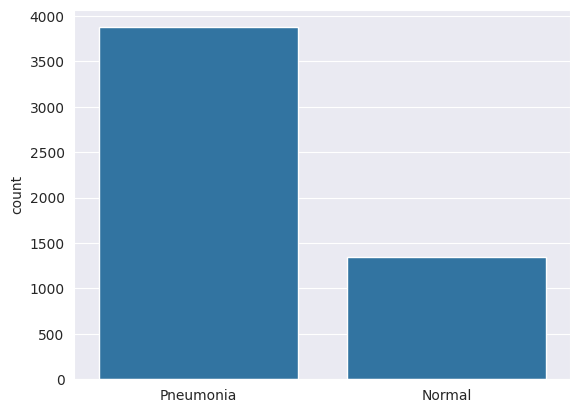

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
print(len(l))
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'NORMAL')

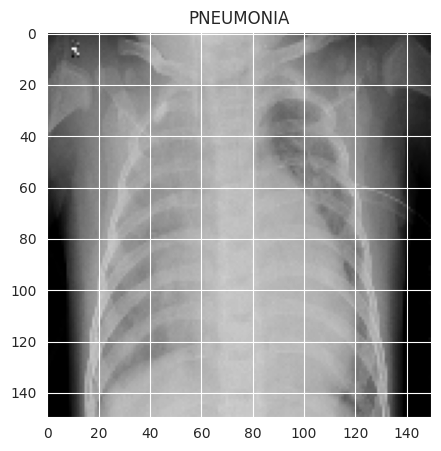

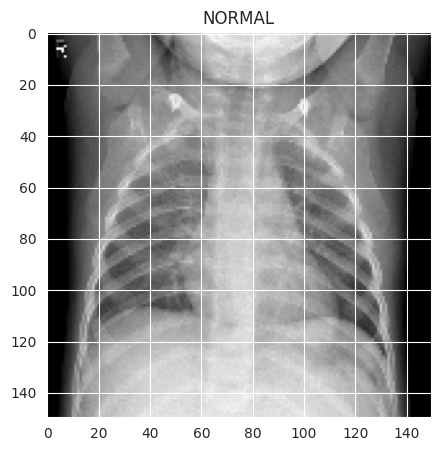

In [ ]:
#Show ảnh phổi bị viêm(vị trí đầu tiên) và ảnh phổi bình thường(vị trí cuối cùng)
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape)

(5216, 150, 150)


In [ ]:
print(x_test.shape)
print(x_val.shape)

(624, 150, 150)
(16, 150, 150)


In [ ]:
image_shape = (150, 150, 1)
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_val = x_val.reshape(x_val.shape[0],*image_shape)

In [ ]:
print(x_train.shape)

(5216, 150, 150, 1)


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)
#datagen.fit(x_train) #sử dụng để tính toán các thống kê (std, mean, ...) cần thiết cho việc normalization của dữ liệu

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 38, 38, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 15 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/15
163/163 [==============================] - 22s 89ms/step - loss: 0.5624 - accuracy: 0.7349 - val_loss: 0.6325 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 13s 81ms/step - loss: 0.4696 - accuracy: 0.7663 - val_loss: 0.7053 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 14s 85ms/step - loss: 0.4343 - accuracy: 0.7933 - val_loss: 0.6394 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.8432
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 14s 84ms/step - loss: 0.3615 - accuracy: 0.8432 - val_loss: 0.6268 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/15
163/163 [==============================] - 14s 85ms/step - loss: 0.2309 - accuracy: 0.9074 - val_loss: 1.0861 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/15
163/163 [==============================

Text(0.5, 1.0, 'Train - Accuracy')

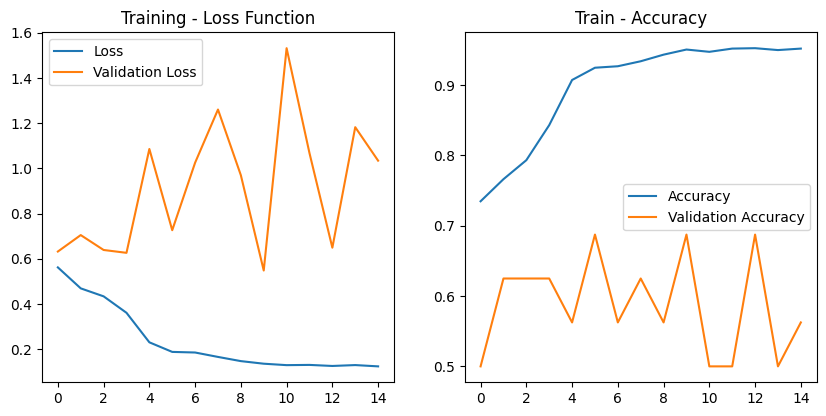

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.3538
Test Accuracy : 0.8830


In [ ]:
predicted_classes = (model.predict(x_test) >= 0.5).astype(int).flatten()
report = classification_report(y_test, predicted_classes)
print(report)

20/20 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       390
           1       0.95      0.73      0.82       234

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



22


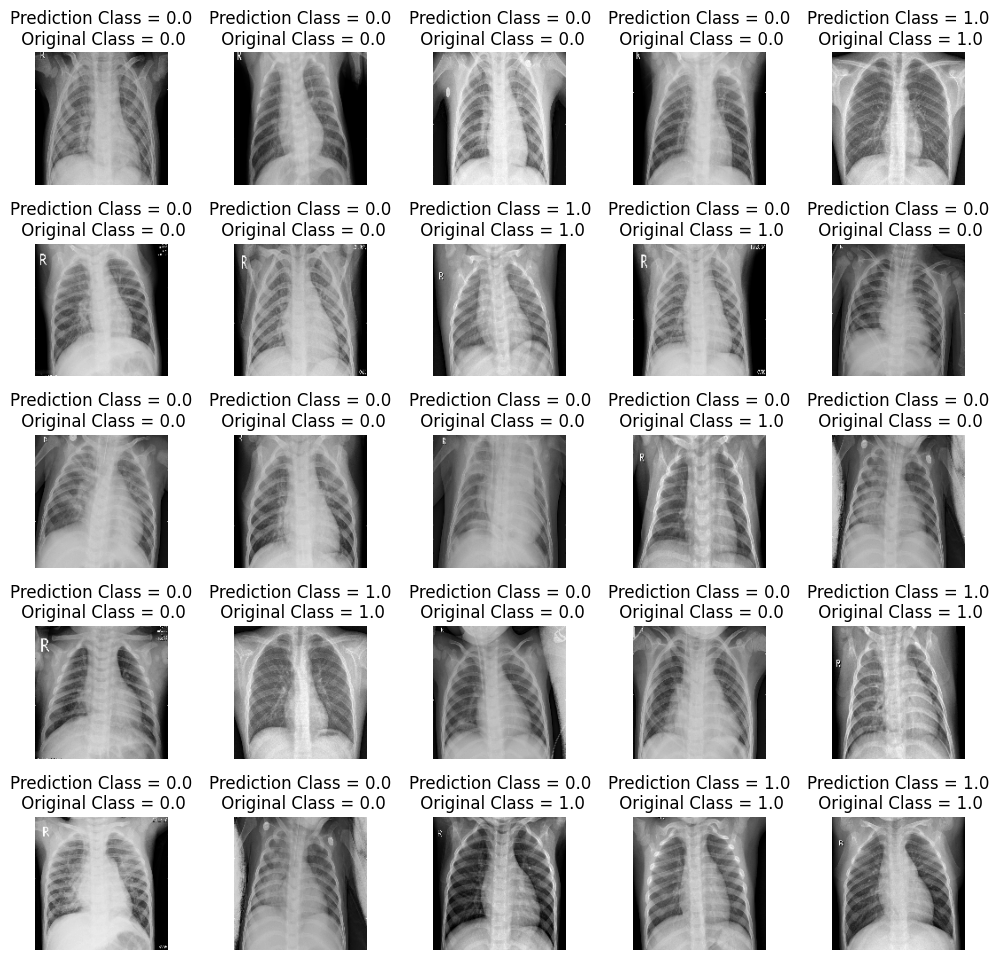

In [ ]:
count = 0
fig, axes = plt.subplots(5, 5, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, 25):
    L = np.random.randint(0, len(x_test))
    axes[i].imshow(x_test[L].reshape(150,150), cmap='gray')
    axes[i].set_title(f"Prediction Class = {predicted_classes[L]:0.1f}\n Original Class = {y_test[L]:0.1f}")
    if predicted_classes[L] == y_test[L]:
      count += 1
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
print(count)

In [ ]:
model.save('Pneumonia_model.keras')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive để truy cập file
from google.colab import drive
drive.mount('/content/gdrive')

# Load model
loaded_model = tf.keras.models.load_model('/content/Pneumonia_model.keras')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


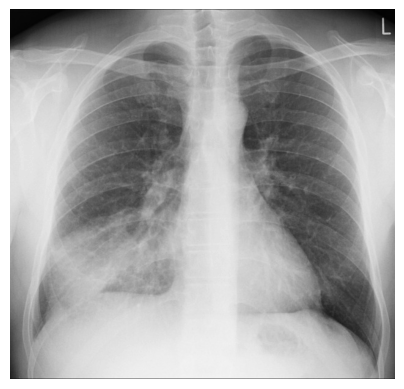

(606, 630)


In [ ]:
#Link: https://www.google.com/url?sa=i&url=https%3A%2F%2Fradiopaedia.org%2Farticles%2Fpneumonia&psig=AOvVaw0Ch2Qd-maDUUtCJPkvhYQC&ust=1705736993699000&source=images&cd=vfe&ved=0CBMQjRxqFwoTCKjmo8776IMDFQAAAAAdAAAAABAE
image_path = '/content/check.jpeg'  #tên ảnh là check

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img, (150, 150))
img_array = np.array(resized_arr) / 255
img_array = img_array.reshape(1, 150, 150, 1)

plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()
print(img.shape)

In [ ]:
predictions = loaded_model.predict(img_array)
if predictions[0] > 0.5:
    print("Dự đoán: Ảnh thuộc lớp NORMAL")
else:
    print("Dự đoán: Ảnh thuộc lớp PNEUMONIA")

1/1 [==============================] - 0s 462ms/step
Dự đoán: Ảnh thuộc lớp NORMAL
